In [2]:
# Main data packages. 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [8]:
df = pd.read_csv("../../data_cleaned/merged/Merge_all_prices_load_gen_res.csv", delimiter=",")

df["period_start_utc"] = pd.to_datetime(df["period_start_utc"], errors="coerce")
df["period_end_utc"] = pd.to_datetime(df["period_end_utc"], errors="coerce")

df["date"] = pd.to_datetime(df["date"], errors="coerce")



In [9]:
df.head(3)

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
0,2015-01-04,2015,1,4,4,23,1,6,22.34,2015-01-04 23:00:00,...,192.125,478.0200,11675.5250,14223.2775,0.0,0.1700,NaN,57028.5925,11867.6500,14701.4675
1,2015-01-05,2015,1,5,5,0,2,0,17.93,2015-01-05 00:00:00,...,192.375,468.5525,11924.5575,14207.5025,0.0,0.2075,NaN,56318.8525,12116.9325,14676.2625
2,2015-01-05,2015,1,5,5,1,2,0,15.17,2015-01-05 01:00:00,...,195.000,465.5550,12000.4075,14439.8025,0.0,0.1800,NaN,56216.6000,12195.4075,14905.5375


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96336 entries, 0 to 96335
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              96336 non-null  datetime64[ns]
 1   year              96336 non-null  int64         
 2   month             96336 non-null  int64         
 3   day               96336 non-null  int64         
 4   dayofyear         96336 non-null  int64         
 5   hour              96336 non-null  int64         
 6   week              96336 non-null  int64         
 7   dayofweek         96336 non-null  int64         
 8   price             96336 non-null  float64       
 9   period_start_utc  96336 non-null  datetime64[ns]
 10  period_end_utc    96336 non-null  datetime64[ns]
 11  c_by_hour         96336 non-null  int64         
 12  load_forecast_da  95229 non-null  float64       
 13  load_actual       96327 non-null  float64       
 14  off_wind_da       9633

In [14]:
df["conv_sum_da"] =  df["load_forecast_da"] - df["res_sum_da"]

df["mw_per_eur"] = df["load_forecast_da"] / df["price"].replace(0, pd.NA)
#df["mw_per_eur"] = df["mw_per_eur"].fillna(0)

df["mw_res_per_eur"] = df["res_sum_da"] / df["price"].replace(0, pd.NA)
#df["mw_res_per_eur"] = df["mw_res_per_eur"].fillna(0)

df["mw_conv_per_eur"] = df["conv_sum_da"] / df["price"].replace(0, pd.NA)
#df["mw_conv_per_eur"] = df["mw_conv_per_eur"].fillna(0)

df["load_diff"] =  df["load_forecast_da"] - df["load_actual"]
df["load_diff_perc"] = (df["load_forecast_da"] - df["load_actual"]) / df["load_forecast_da"].replace(0, pd.NA) * 100

df["gen_diff"] =  df["gen_forecast_da"] - df["gen_actual"]
df["gen_diff_perc"] = (df["gen_forecast_da"] - df["gen_actual"]) / df["gen_forecast_da"].replace(0, pd.NA) * 100

df["res_diff"] =  df["res_sum_da"] - df["res_sum_act"]
df["res_diff_perc"] = (df["res_diff"]) / df["res_sum_da"].replace(0, pd.NA) * 100

df["load_gen_diff_da"] =  df["load_forecast_da"] - df["gen_forecast_da"]
df["load_gen_diff_da_perc"] = df["load_gen_diff_da"] / df["load_forecast_da"].replace(0, pd.NA) * 100

df["load_gen_diff_actual"] =  df["load_actual"] - df["gen_actual"]
df["load_gen_diff_actual_perc"] = df["load_gen_diff_actual"] / df["load_actual"].replace(0, pd.NA) * 100


In [16]:
import matplotlib.dates as mdates

def plot_dual_axis_daily(
    df,
    years=None,                 # list of years, e.g. [2018, 2019]
    year_range=None,            # tuple, e.g. (2018, 2020)
    left_cols=None,             # list of columns for left y-axis
    right_cols=None,            # list of columns for right y-axis
    left_ylim=None,             # tuple (min, max) or None for auto
    right_ylim=None,            # tuple (min, max) or None for auto
    x_tick="month",             # "month", "quarter", "auto"
    x_minor="week",             # "week", None
    add_week_lines=True         # True/False
):
    df_plot = df.copy()
    df_plot["period_start_utc"] = pd.to_datetime(df_plot["period_start_utc"], errors="coerce")
    df_plot = df_plot.dropna(subset=["period_start_utc"])

    if years is not None:
        df_plot = df_plot[df_plot["year"].isin(years)]
    elif year_range is not None:
        y0, y1 = year_range
        df_plot = df_plot[(df_plot["year"] >= y0) & (df_plot["year"] <= y1)]

    df_plot = df_plot.sort_values("period_start_utc")

    left_cols = left_cols or []
    right_cols = right_cols or []
    cols = list(dict.fromkeys(left_cols + right_cols))

    df_daily = (
        df_plot
        .set_index("period_start_utc")[cols]
        .resample("D")
        .mean()
        .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(14, 6))

    for col in left_cols:
        ax1.plot(df_daily["period_start_utc"], df_daily[col], linewidth=1.2, label=col)
    ax1.set_ylabel(", ".join(left_cols) if left_cols else "")

    ax2 = ax1.twinx()
    for col in right_cols:
        ax2.plot(df_daily["period_start_utc"], df_daily[col], alpha=0.6, linewidth=0.8, label=col)
    ax2.set_ylabel(", ".join(right_cols) if right_cols else "")

    if left_ylim is not None:
        ax1.set_ylim(left_ylim)
    if right_ylim is not None:
        ax2.set_ylim(right_ylim)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", ncol=2, fontsize=8)

    if x_tick == "month":
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    elif x_tick == "quarter":
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    if x_minor == "week":
        ax1.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    if add_week_lines and not df_daily.empty:
        for dt in pd.date_range(
            df_daily["period_start_utc"].min(),
            df_daily["period_start_utc"].max(),
            freq="W-MON"
        ):
            ax1.axvline(dt, color="gray", linewidth=0.3, alpha=0.4)

    plt.tight_layout()
    plt.show()





2015 2025 [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
period_start_utc       0
load_diff_perc      1109
load_diff           1109
dtype: int64


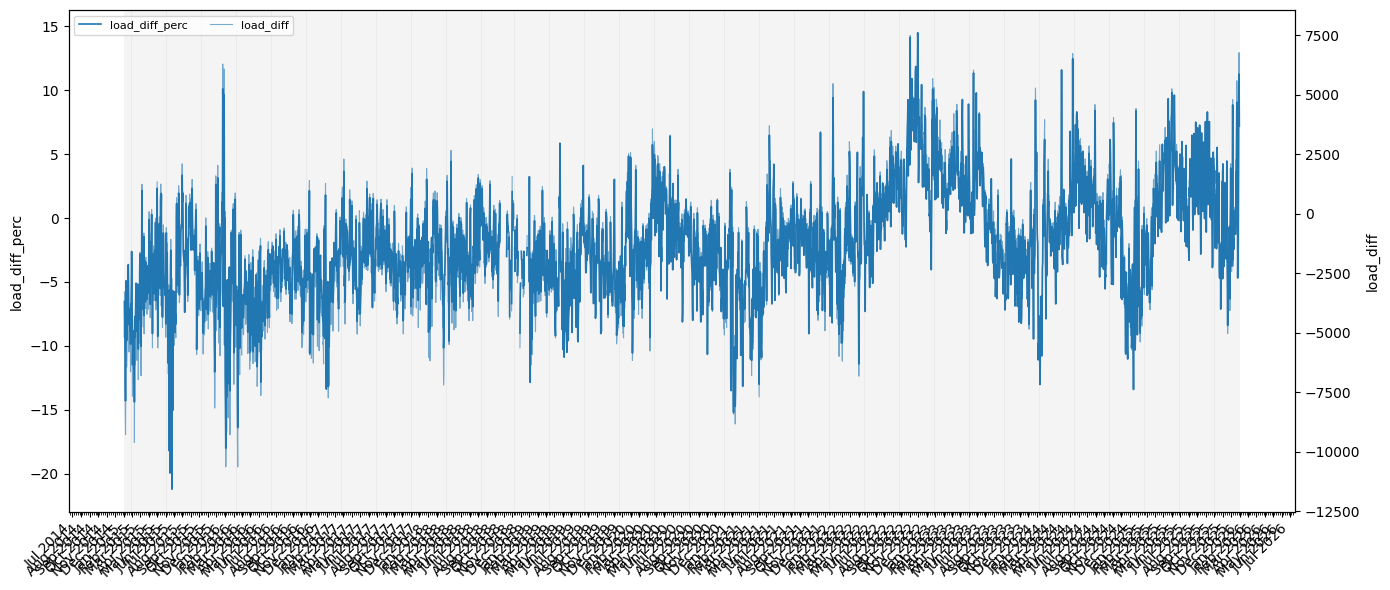

In [17]:
# quick debug
print(df["year"].min(), df["year"].max(), df["year"].unique()[:10])
print(df[["period_start_utc","load_diff_perc","load_diff"]].isna().sum())

# test without year filter
plot_dual_axis_daily(
    df,
    years=None,
    left_cols=["load_diff_perc"],
    right_cols=["load_diff"]
)


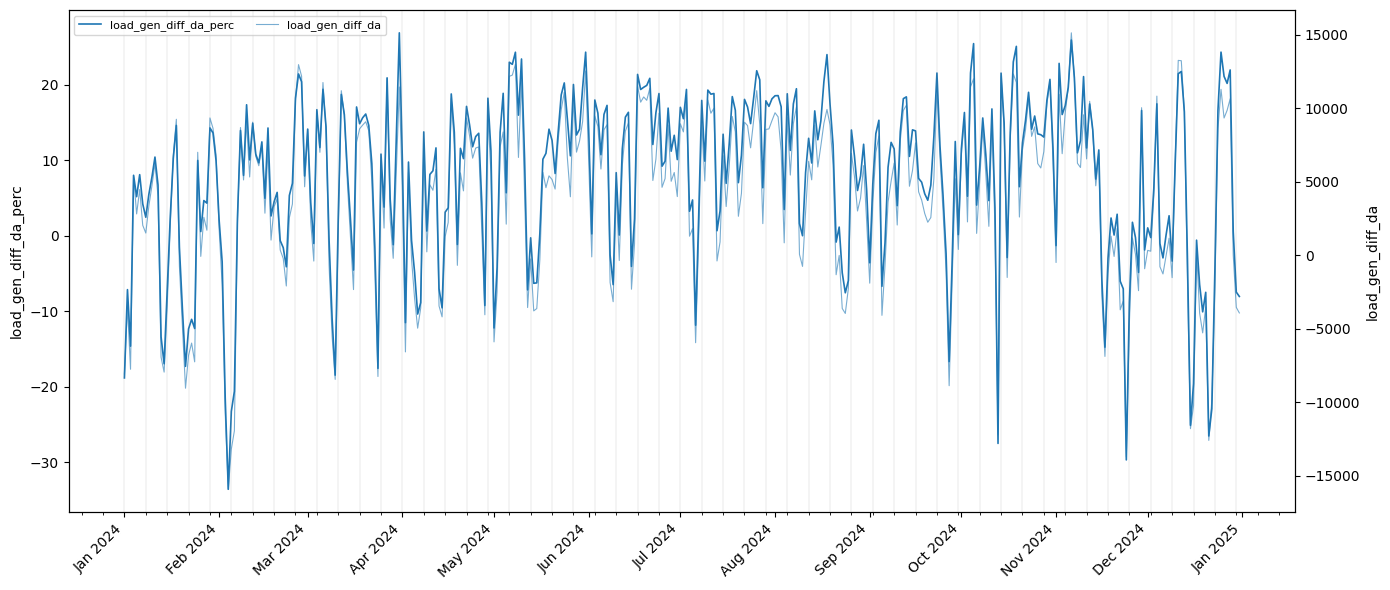

In [21]:
# Example
plot_dual_axis_daily(
    df,
    years=[2024],
    left_cols=["load_gen_diff_da_perc"],
    right_cols=["load_gen_diff_da"],
    left_ylim=None,
    right_ylim=None,
    x_tick="month",
    x_minor="week",
    add_week_lines=True
)

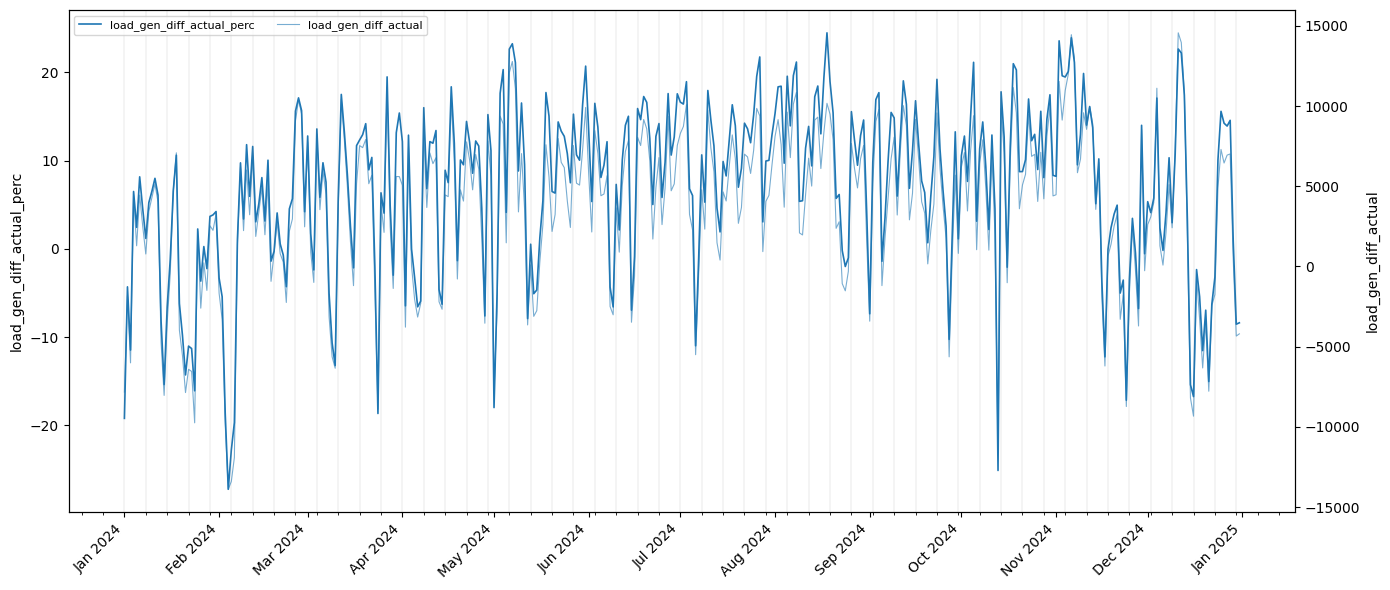

In [22]:
# Example
plot_dual_axis_daily(
    df,
    years=[2024],
    left_cols=["load_gen_diff_actual_perc"],
    right_cols=["load_gen_diff_actual"],
    left_ylim=None,
    right_ylim=None,
    x_tick="month",
    x_minor="week",
    add_week_lines=True
)

In [ ]:
plot_dual_axis_daily(
    df,
    years=[2018],
    left_cols=["load_diff_perc"],
    right_cols=["load_diff"],
    left_ylim=None,
    right_ylim=None,
    x_tick="month",
    x_minor="week",
    add_week_lines=True
)

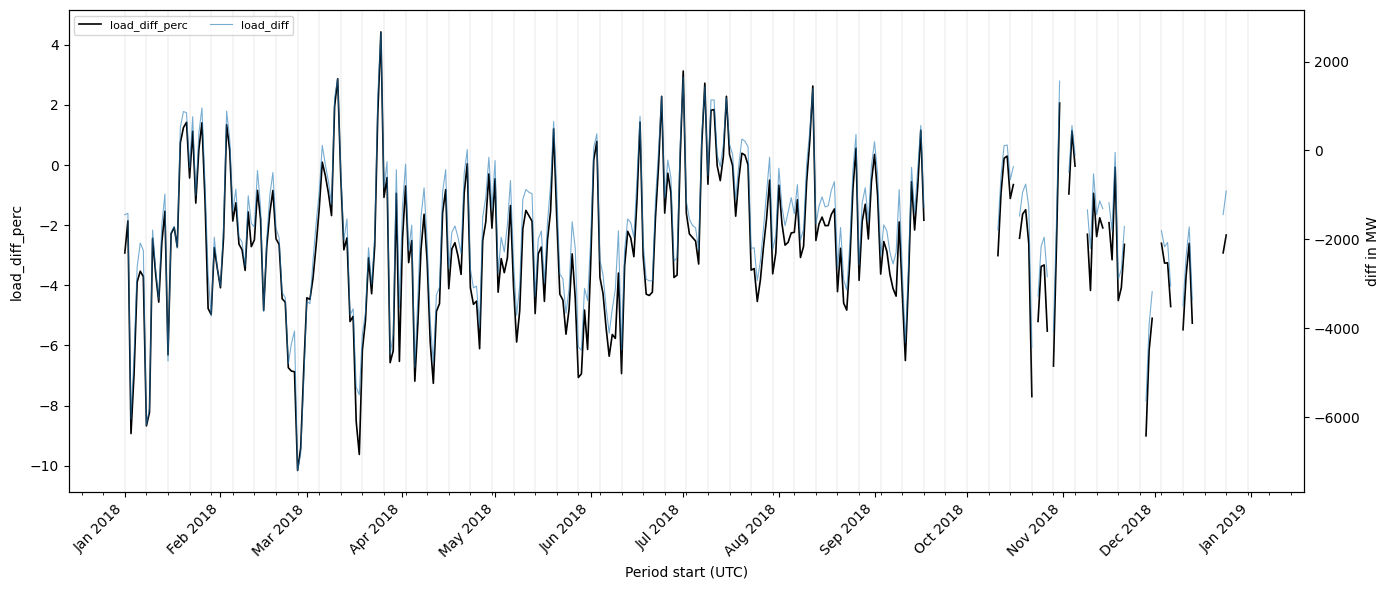

In [15]:


feature_cols = ["load_diff"]

df_plot = df.copy()
#df_plot["period_start_utc"] = pd.to_datetime(df_plot["period_start_utc"], errors="coerce")
years = [2018]
df_plot = df_plot[df_plot["year"].isin(years)].copy()
df_plot = df_plot.sort_values("period_start_utc")

df_daily = (
    df_plot
    .set_index("period_start_utc")[["load_diff_perc"] + feature_cols]
    .resample("D")
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df_daily["period_start_utc"], df_daily["load_diff_perc"], color="black", linewidth=1.2, label="load_diff_perc")
ax1.set_ylabel("load_diff_perc")
ax1.set_xlabel("Period start (UTC)")

ax2 = ax1.twinx()
for col in feature_cols:
    ax2.plot(df_daily["period_start_utc"], df_daily[col], alpha=0.6, linewidth=0.8, label=col)
ax2.set_ylabel("diff in MW")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", ncol=2, fontsize=8)

# Better month labels + weekly lines
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax1.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

for dt in pd.date_range(
    df_daily["period_start_utc"].min(),
    df_daily["period_start_utc"].max(),
    freq="W-MON"
):
    ax1.axvline(dt, color="gray", linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()



In [6]:
df.columns

Index(['date', 'year', 'month', 'day', 'dayofyear', 'hour', 'week',
       'dayofweek', 'price', 'period_start_utc', 'period_end_utc', 'c_by_hour',
       'load_forecast_da', 'load_actual', 'off_wind_da', 'off_wind_act',
       'on_wind_da', 'on_wind_act', 'solar_da', 'solar_act', 'gen_forecast_da',
       'gen_actual', 'res_sum_da', 'res_sum_act', 'conv_sum_da', 'mw_per_eur',
       'mw_res_per_eur', 'mw_conv_per_eur'],
      dtype='object')

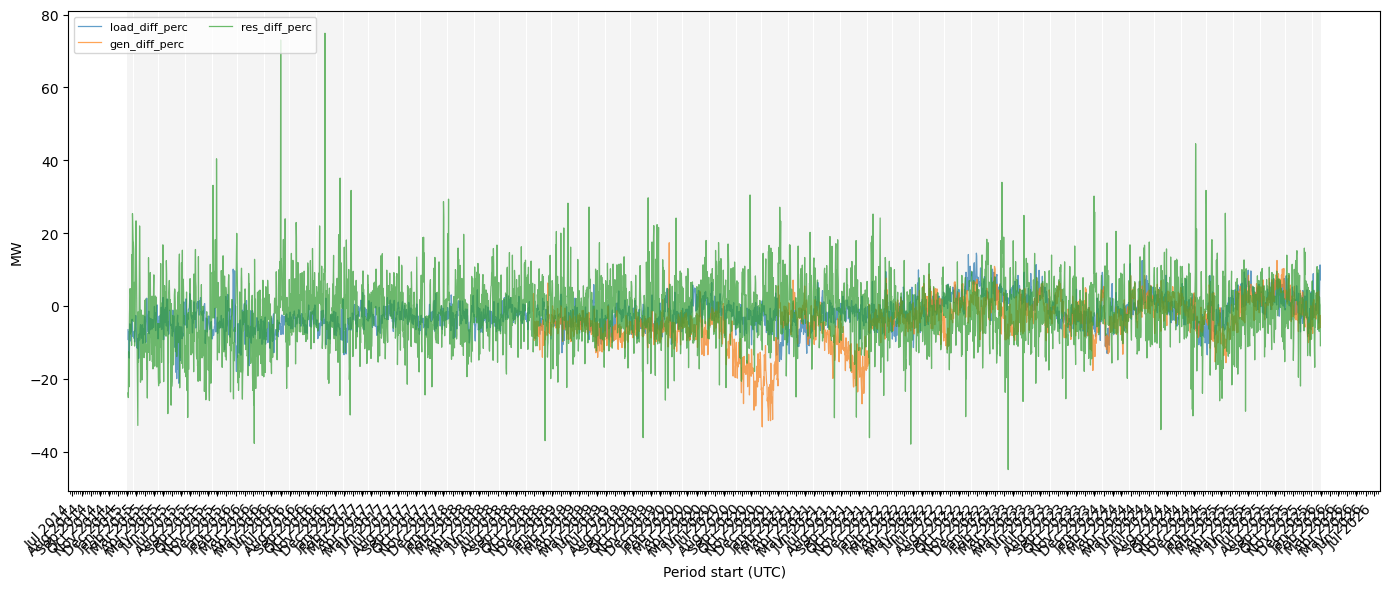

In [20]:

# feature_cols = ["load_forecast_da", "res_sum_da"]
feature_cols =["load_diff_perc","gen_diff_perc","res_diff_perc"]
    #["mw_per_eur"] #,"mw_conv_per_eur", "mw_res_per_eur"]

df_plot = df.copy()
df_plot["period_start_utc"] = pd.to_datetime(df_plot["period_start_utc"], errors="coerce")
# years = [2023, 2024, 2025]
# df_plot = df_plot[df_plot["year"].isin(years)].copy()
df_plot = df_plot.sort_values("period_start_utc")

df_daily = (
    df_plot
    .set_index("period_start_utc")[feature_cols]
    .resample("D")
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(14, 6))

y_min = -300
y_max = 1700  # set your desired max

#ax.set_ylim(y_min, y_max)

for col in feature_cols:
    ax.plot(df_daily["period_start_utc"], df_daily[col], alpha=0.7, linewidth=0.9, label=col)

ax.set_ylabel("MW")
ax.set_xlabel("Period start (UTC)")

ax.legend(loc="upper left", ncol=2, fontsize=8)

# Better month labels + weekly lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for dt in pd.date_range(
    df_daily["period_start_utc"].min(),
    df_daily["period_start_utc"].max(),
    freq="W-MON"
):
    ax.axvline(dt, color="gray", linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()
